# Redes Neuronales Recurrentes

Basado en https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Las redes neuronales recurrentes permiten hacer predicción con series de tiempo, aprendiendo las relaciones de dependencia secuencial entre valores numéricos.

Para ilustrar la aplicación de estos modelos para el forecasting con series de tiempo, vamos a considerar un dataset con datos históricos muy conocido que describe la evolución del número de pasajeros aéreos de enero de 1949 a diciembre de 1960 (144 pasos de tiempo).

Vamos a utilizar redes LSTM en Keras.

## Exploración y preparación de los datos

Cargamos el archivo de datos y lo exploramos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
path = "D:/Usuarios/94501228/Dropbox/Cursos_Propios/MIT - Deep Learning/06 - RNN/PasajerosAereos.csv"
dataset = pd.read_csv(path, usecols=[1])#, engine='python', skipfooter=3)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
Pasajeros    144 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB


In [4]:
dataset.head()

,Pasajeros
0,112
1,118
2,132
3,129
4,121


In [5]:
dataset.describe()

,Pasajeros
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


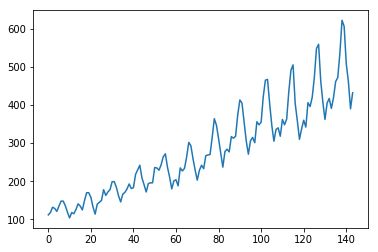

In [6]:
plt.plot(dataset)
plt.show()

Podemos ver que existe una periodicidad de los datos encontrados. Fácilmente podemos encontrar los 12 años que abarcan los datos. Además, se puede notar que existe una tendencia positiva.

Los LSTMs son sensibles a la escala de los datos. Idealmente deberían tener pequeños valores, por lo que vamos a normalizarlos para que queden entre 0 y 1.

In [7]:
dataset = dataset.values.astype('float32')

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Para poder validar el modelo, vamos a particionar el dataset en training y test set:

In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Para poder crear batches (muestras) de tratamiento para aprender el modelo de forecasting, vamos a definir la función siguiente que, dado un array con los datos de una serie de tiempo, y un número de pasos de tiempo a considerar en el pasado (lookback), produce una matriz con los datos organizados para ser consumidos por la red neuronal recurrente.

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return (np.asarray(dataX), np.asarray(dataY))

Por ejemplo, veamos lo que produce esta función con el dataset actual.

In [11]:
dataset[0:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [12]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
trainX[0:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [14]:
trainY[0:5]

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557],
      dtype=float32)

In [15]:
trainX.shape

(94, 1)

La red LSTM espera recibir los datos de entrenamiento con la forma [samples, timesteps, features]. En este caso vamos a tener 94 samples de entrada, 1 solo paso de tiempo, y un feature de entrada (lookback = 1).

En el estado actual tenemos los datasets de los inputs (variables predictivas X) con la forma [samples, features], por lo que necesitamos modificarlo. Utilizamos entonces la función reshape.

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
trainX.shape

(94, 1, 1)

## Aplicación de LSTMs para la predicción

Vamos a tratar de resolver la pregunta siguiente: "Dados los datos históricos de número de pasajeros mensuales, podemos predecir el número de pasajeros del mes siguiente?"

### Modelo inicial: considera el dato anterior

Comenzamos con un modelo muy sencillo con 1 solo input, una capa escondida con 4 bloques LSTM, y una sola neurona de salida con la predicción del siguiente valor de la serie de tiempo (función de activación por defecto lineal). 
En los bloques LSTM vamos a utilizar la función de activación por defecto. 
Entrenamos los parámetros durante 100 épocas con un batch de tamaño 1 (Stochastic Gradient Descent).

In [19]:
np.random.seed(7)

In [20]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0202
Epoch 3/100
 - 0s - loss: 0.0146
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

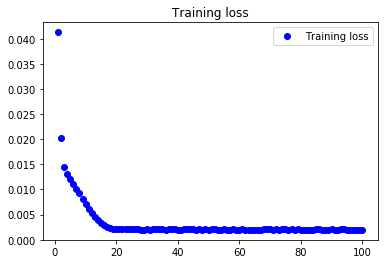

In [29]:
loss = history.history["loss"]
epocas =  range(1,101)

plt.figure()
plt.plot(epocas, loss, "bo", label="Training loss")
plt.title("Training loss")
plt.legend()
plt.show()

Vamos a ver como nos fue con la calidad de la predicción. Para poder obtener las predicciones en las unidades originales (número de pasajeros), vamos a invertir el cambio de escala. Utilizamos el RMSE como métrica de evaluación.

In [30]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [31]:
np.squeeze(trainPredict)[0:5]

array([124.27634, 129.4215 , 141.62347, 138.98637, 132.01344],
      dtype=float32)

In [32]:
np.squeeze(trainY)[0:5]

array([117.99999916, 131.99999879, 129.00000163, 120.99999632,
       135.00000368])

In [33]:
np.squeeze(testPredict)[0:5]

array([314.82596, 301.37778, 353.67957, 346.17392, 352.74368],
      dtype=float32)

In [34]:
np.squeeze(testY)[0:5]

array([301.00001152, 355.999993  , 348.00001085, 355.00000681,
       421.9999924 ])

In [35]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.92 RMSE
Test Score: 47.53 RMSE


Vamos a decalar de un paso de tiempo las predicciones, pues así se tenga el primer valor real de la serie, no se tiene el valor predicho correspondiente.

In [36]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
print(trainPredictPlot[0:5])

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
print(testPredictPlot[-6:-1])

[[      nan]
 [124.27634]
 [129.4215 ]
 [141.62347]
 [138.98637]]
[[507.3264 ]
 [570.98047]
 [559.7904 ]
 [486.11057]
 [447.4635 ]]


La serie predicha de entreamiento tiene solo valores para los primeros 2 tercios de los datos, la de test solo para el último tercio.

Veamos gráficamente la calidad de las predicciones comparadas con los valores reales.

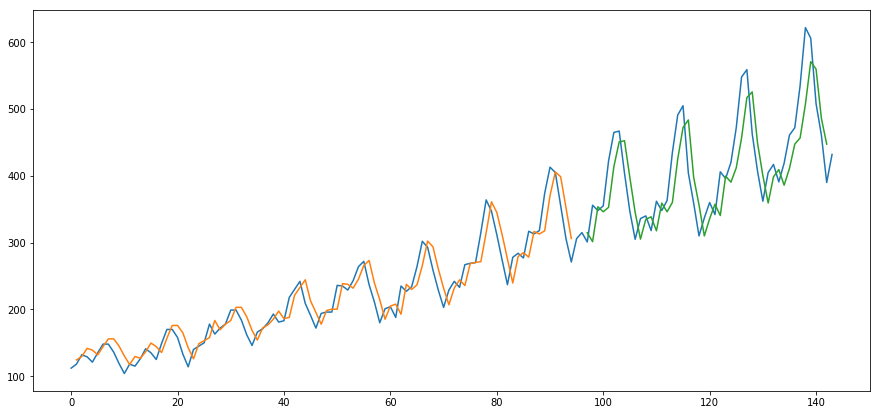

In [37]:
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(dataset)) # en azul
plt.plot(trainPredictPlot) # en naranja
plt.plot(testPredictPlot) # en verde
plt.show()

### 2. Modelo que considera una ventana de datos anteriores como diferentes features

Vamos ahora a considerar la ventana de los últimos 3 valores para predecir el siguiente valor.
Conservamos el mismo modelo con los 4 bloques LSTM.

In [40]:
np.random.seed(7)

In [41]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
trainX[0:5]

array([[0.01544401, 0.02702703, 0.05405405],
       [0.02702703, 0.05405405, 0.04826255],
       [0.05405405, 0.04826255, 0.03281853],
       [0.04826255, 0.03281853, 0.05984557],
       [0.03281853, 0.05984557, 0.08494207]], dtype=float32)

In [43]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [44]:
trainX.shape

(92, 1, 3)

Tenemos ahora que cada valor de la ventan de tiempo se considera como un feature diferente.

In [45]:
model2 = Sequential()
model2.add(LSTM(4, input_shape=(1, look_back)))
model2.add(Dense(1))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [46]:
model2.compile(loss='mean_squared_error', optimizer='adam')
history = model2.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0542
Epoch 2/100
 - 0s - loss: 0.0259
Epoch 3/100
 - 0s - loss: 0.0167
Epoch 4/100
 - 0s - loss: 0.0145
Epoch 5/100
 - 0s - loss: 0.0129
Epoch 6/100
 - 0s - loss: 0.0116
Epoch 7/100
 - 0s - loss: 0.0105
Epoch 8/100
 - 0s - loss: 0.0094
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0074
Epoch 11/100
 - 0s - loss: 0.0066
Epoch 12/100
 - 0s - loss: 0.0060
Epoch 13/100
 - 0s - loss: 0.0056
Epoch 14/100
 - 0s - loss: 0.0052
Epoch 15/100
 - 0s - loss: 0.0050
Epoch 16/100
 - 0s - loss: 0.0049
Epoch 17/100
 - 0s - loss: 0.0046
Epoch 18/100
 - 0s - loss: 0.0045
Epoch 19/100
 - 0s - loss: 0.0045
Epoch 20/100
 - 0s - loss: 0.0043
Epoch 21/100
 - 0s - loss: 0.0043
Epoch 22/100
 - 0s - loss: 0.0042
Epoch 23/100
 - 0s - loss: 0.0042
Epoch 24/100
 - 0s - loss: 0.0042
Epoch 25/100
 - 0s - loss: 0.0040
Epoch 26/100
 - 0s - loss: 0.0041
Epoch 27/100
 - 0s - loss: 0.0040
Epoch 28/100
 - 0s - loss: 0.0040
Epoch 29/100
 - 0s - loss: 0.0039
Epoch 30/100
 - 0s - lo

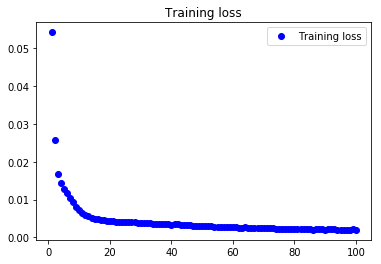

In [47]:
loss = history.history["loss"]
epocas =  range(1,101)

plt.figure()
plt.plot(epocas, loss, "bo", label="Training loss")
plt.title("Training loss")
plt.legend()
plt.show()

In [48]:
trainPredict = model2.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = model2.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [49]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.19 RMSE
Test Score: 58.03 RMSE


Vamos a decalar las predicciones teniendo en cuenta los pasos de tiempo correspondientes.

In [50]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
print(trainPredictPlot[0:5])

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
print(testPredictPlot[-6:-1])

[[      nan]
 [      nan]
 [      nan]
 [136.12057]
 [134.67914]]
[[485.75943]
 [570.5385 ]
 [535.79456]
 [402.17877]
 [357.81482]]


La serie predicha de entreamiento tiene solo valores para los primeros 2 tercios de los datos, la de test solo para el último tercio.

Veamos gráficamente la calidad de las predicciones comparadas con los valores reales.

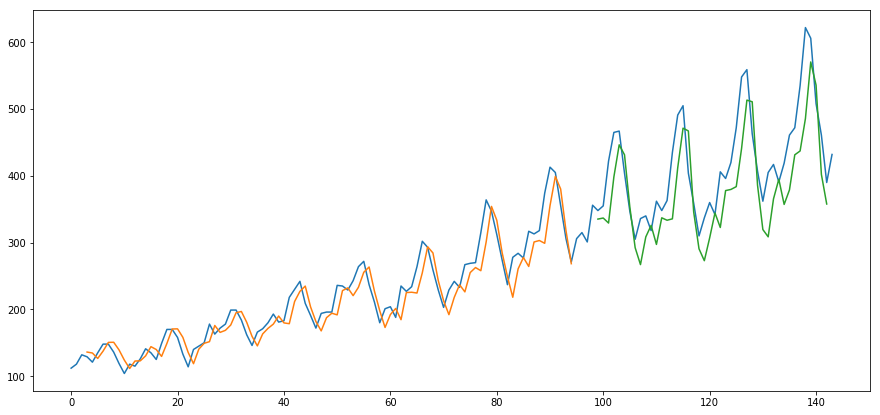

In [51]:
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(dataset)) # en azul
plt.plot(trainPredictPlot) # en naranja
plt.plot(testPredictPlot) # en verde
plt.show()

Vemos aue los errores son un poco mayores que en el caso anterior. Habría que definir mejor la ventana de los datos de entrada a utilizar para minimizar la predicción.

### 3. Modelo que considera una ventana de datos anteriores como pasos de tiempo diferentes

En el caso de la ventana con tamaño 3, los inputs de la red eran de la forma [92, 1, 3], cada valor anterior de la ventana lo considerabamos como un feature diferente.

Ahora vamos a considerarlos como diferentes pasos de tiempo, pasando entonces a una forma [92, 3, 1]. De esta manera consideramos que se trata del mismo feature en momento de tiempo diferentes.

In [53]:
np.random.seed(7)

In [54]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [55]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [56]:
trainX.shape

(92, 3, 1)

Tenemos tambien que cambiar la forma de entrada del modelo

In [57]:
model3 = Sequential()
model3.add(LSTM(4, input_shape=(look_back, 1)))
model3.add(Dense(1))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [58]:
model3.compile(loss='mean_squared_error', optimizer='adam')
history = model3.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0287
Epoch 2/100
 - 0s - loss: 0.0118
Epoch 3/100
 - 0s - loss: 0.0097
Epoch 4/100
 - 0s - loss: 0.0086
Epoch 5/100
 - 0s - loss: 0.0075
Epoch 6/100
 - 0s - loss: 0.0065
Epoch 7/100
 - 0s - loss: 0.0058
Epoch 8/100
 - 0s - loss: 0.0053
Epoch 9/100
 - 0s - loss: 0.0046
Epoch 10/100
 - 0s - loss: 0.0044
Epoch 11/100
 - 0s - loss: 0.0041
Epoch 12/100
 - 0s - loss: 0.0041
Epoch 13/100
 - 0s - loss: 0.0040
Epoch 14/100
 - 0s - loss: 0.0039
Epoch 15/100
 - 0s - loss: 0.0039
Epoch 16/100
 - 0s - loss: 0.0039
Epoch 17/100
 - 0s - loss: 0.0038
Epoch 18/100
 - 0s - loss: 0.0039
Epoch 19/100
 - 0s - loss: 0.0038
Epoch 20/100
 - 0s - loss: 0.0038
Epoch 21/100
 - 0s - loss: 0.0038
Epoch 22/100
 - 0s - loss: 0.0038
Epoch 23/100
 - 0s - loss: 0.0037
Epoch 24/100
 - 0s - loss: 0.0038
Epoch 25/100
 - 0s - loss: 0.0037
Epoch 26/100
 - 0s - loss: 0.0038
Epoch 27/100
 - 0s - loss: 0.0037
Epoch 28/100
 - 0s - loss: 0.0038
Epoch 29/100
 - 0s - loss: 0.0037
Epoch 30/100
 - 0s - lo

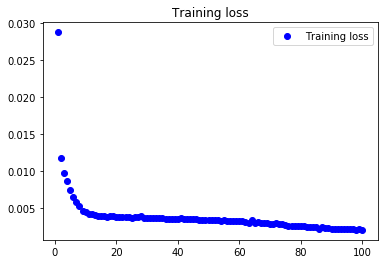

In [59]:
loss = history.history["loss"]
epocas =  range(1,101)

plt.figure()
plt.plot(epocas, loss, "bo", label="Training loss")
plt.title("Training loss")
plt.legend()
plt.show()

In [60]:
trainPredict = model3.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = model3.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [61]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.70 RMSE
Test Score: 58.80 RMSE


Vamos a decalar las predicciones teniendo en cuenta los pasos de tiempo correspondientes.

In [62]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
print(trainPredictPlot[0:5])

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
print(testPredictPlot[-6:-1])

[[      nan]
 [      nan]
 [      nan]
 [129.80063]
 [130.71924]]
[[472.84744]
 [535.6833 ]
 [515.9305 ]
 [438.10153]
 [407.33963]]


La serie predicha de entreamiento tiene solo valores para los primeros 2 tercios de los datos, la de test solo para el último tercio.

Veamos gráficamente la calidad de las predicciones comparadas con los valores reales.

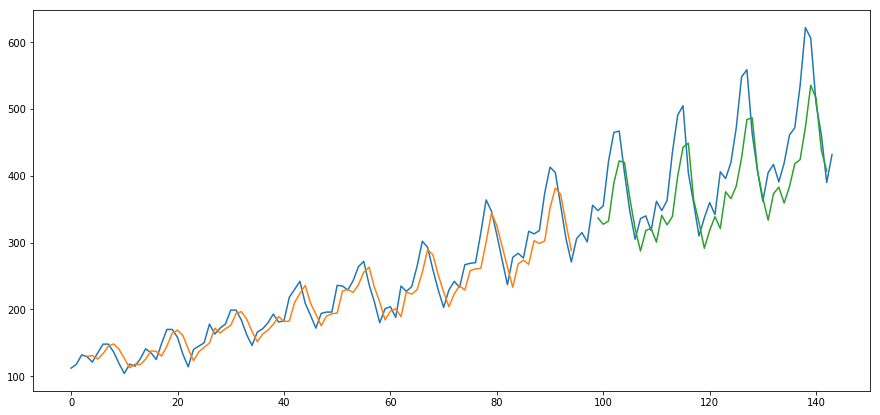

In [63]:
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(dataset)) # en azul
plt.plot(trainPredictPlot) # en naranja
plt.plot(testPredictPlot) # en verde
plt.show()

Vemos que los errores de entrenamiento son un poco mayores que en el caso anterior, pero no en el caso del set de test.

### 4. Modelo con memoria entre los diferentes batches

La red LSTM tiene memoria, lo que le permite recordar patrones dentre de largas secuencias.

Normalmente, el estado dentro de una red se resetea después de cada batch de entrenamiento cuando se está ajustando el modelo, al igual que con cada llamada a las funciones de predicción (model.predict()).

Podemos controlar cuando se "limpia" la memoria dentro de un LSTM en Keras, haciendo que la capa LSTM sea "stateful" (**stateful = True** en la creación de la capa LSTM), lo que significa que va a construir el estado interno sobre la totalidad de la secuencia de entrenamiento. Se tiene además que especificar el **batch_input_shape** en vez del parámetro input_shape, definiendo en duro el número de samples (batch_size) en el momento de crear la capa LSTM y en el momento de utilizar el modelo para predecir (model.predict()).

Los datos de entrada deben presentarse entonces en el orden temporal definido. Además, es necesario explícitamente resetear el estado de la red despues de cada época, con llamadas a **model.reset_states()**. Esto implica que se tenga que crear un loop externo de épocas.

Veamos como cambian los resultados:

In [64]:
np.random.seed(7)

In [65]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [66]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [67]:
batch_size=1

In [68]:
model4 = Sequential()
model4.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model4.add(Dense(1))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [69]:
model4.compile(loss='mean_squared_error', optimizer='adam')

for i in range(100):
    model4.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model4.reset_states()

Epoch 1/1
 - 1s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0082
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0034
Epoch 1/1
 - 0s - loss: 0.0033
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0031
Epoch 1/1
 - 0s - loss: 0.0030
Epoch 1/1
 - 0s - loss: 0.0029
Epoch 1/

In [70]:
trainPredict = model4.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

model.reset_states()

testPredict = model4.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [71]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.79 RMSE
Test Score: 54.62 RMSE


Ya tenemos un mucho mejor de entrenamiento, mas no de test

In [72]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
print(trainPredictPlot[0:5])

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
print(testPredictPlot[-6:-1])

[[      nan]
 [      nan]
 [      nan]
 [143.27089]
 [138.89316]]
[[481.35004]
 [544.50836]
 [481.39536]
 [375.48013]
 [360.9473 ]]


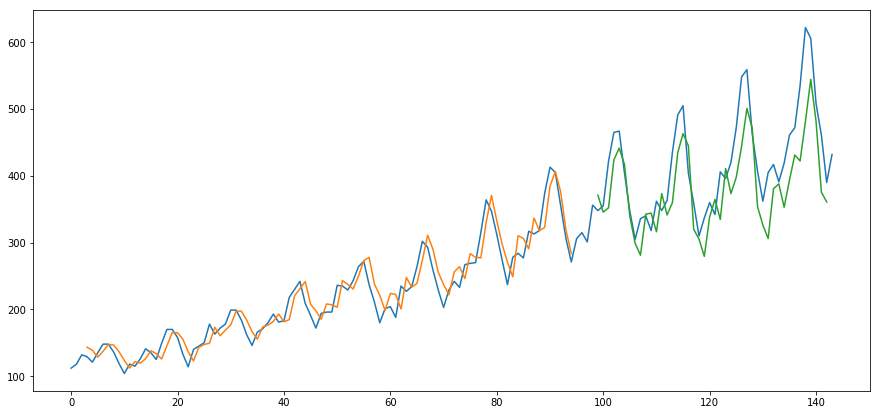

In [73]:
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(dataset)) # en azul
plt.plot(trainPredictPlot) # en naranja
plt.plot(testPredictPlot) # en verde
plt.show()

Vemos que los errores de entrenamiento son un poco mayores que en el caso anterior, y set de test, mas no si comparamos a nuestro primer modelo.

### 5. Múltiples capas LSTM interconectadas

Finalmente, vamos a aprovechar uno de los grandes beneficios de las capas LSTMs: el hecho de que se puedan apilar dentro de la arquitectura de en un mismo modelo.

La única diferencia en Keras con respecto a otos tipos de capas, es que se requiere que una capa LSTM que precede otra capa LSTM debe retornar la secuencia de proceso. Esto se logra utilizando con el parámetro **return_sequences=True**.

Retomamos el último modelo agregándole otra capa LSTM.

In [74]:
np.random.seed(7)

In [75]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [76]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [77]:
batch_size=1

In [78]:
model5 = Sequential()
model5.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model5.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model5.add(Dense(1))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 3, 4)                 96        
_________________________________________________________________
lstm_6 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [79]:
model5.compile(loss='mean_squared_error', optimizer='adam')

for i in range(100):
    model5.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model5.reset_states()

Epoch 1/1
 - 2s - loss: 0.0057
Epoch 1/1
 - 0s - loss: 0.0142
Epoch 1/1
 - 0s - loss: 0.0100
Epoch 1/1
 - 0s - loss: 0.0072
Epoch 1/1
 - 0s - loss: 0.0060
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/

In [80]:
trainPredict = model5.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

model.reset_states()

testPredict = model5.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [81]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 29.87 RMSE
Test Score: 78.41 RMSE


En este caso no nos ayudó para nada el apilamiento de las capas, pero el propósito con este caso era mostrar el tipo de acciones posibles en la definición de la arquitectura de un modelo recurrente para los problemas de forecasting.

In [82]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
print(trainPredictPlot[0:5])

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
print(testPredictPlot[-6:-1])

[[      nan]
 [      nan]
 [      nan]
 [124.23465]
 [132.61832]]
[[407.60336]
 [437.85532]
 [435.32727]
 [399.18924]
 [375.56244]]


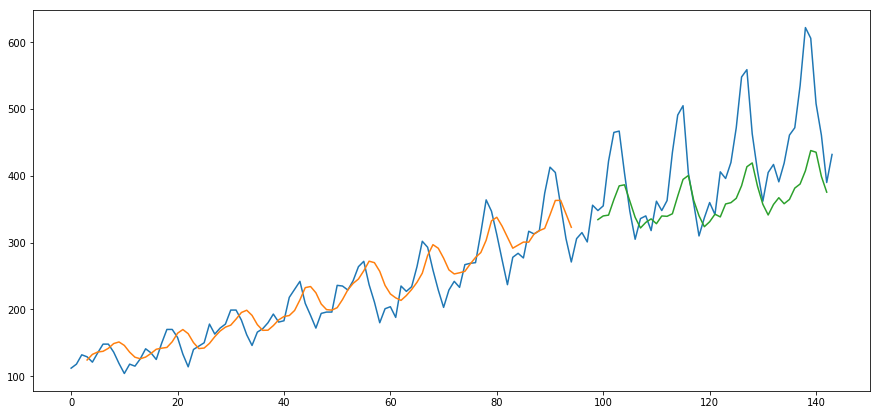

In [83]:
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(dataset)) # en azul
plt.plot(trainPredictPlot) # en naranja
plt.plot(testPredictPlot) # en verde
plt.show()

Vemos que los errores de entrenamiento son un poco mayores que en el caso anterior, y set de test, mas no si comparamos a nuestro primer modelo.